In [ ]:
from data_utils import load_task, vectorize_data
from itertools import chain
from six.moves import range, reduce
import time
import util

batch_size=32



queries=util.load_queries_morp()
train=[]
for idx in range(len(queries)):
    train.append([util.load_stories_with_query_using_title_more(queries[idx][0]),queries[idx][0],queries[idx][1],1])
    
import pickle
for idx in range(len(train)):
    pickle.dump(train[idx],open("./korean_memnet_search_data/korean_memnet_search_data_using_title_more_"+str(idx)+".pkl","wb"))

vocab=[]
story_max=0

for stories,query,answer,flag in train:
    story_max=max(story_max,len(stories))
    for sent in stories:
        for word in sent:
            vocab.append(word)
    for word in query:
        vocab.append(word)
    for word in answer:
        vocab.append(word)
vocab=list(set(vocab))

pickle.dump([vocab,story_max],open("./korean_memnet_search_data/vocab_story_max_using_title_more.pkl","wb"))

In [ ]:
import pickle
import time
story_size_list=[]
for idx in range(231):
    data=pickle.load(open("./korean_memnet_search_data/korean_memnet_search_data_using_title_more_"+str(idx)+".pkl","rb"))
    story_size=len(data[0])
    story_size_list.append(story_size)
import matplotlib.pyplot as plt
%matplotlib nbagg

plt.hist(story_size_list,bins=100,cumulative=True)
plt.title("story size histogram")
plt.xlabel("story size")
plt.ylabel("frequency")

In [1]:
import pickle
import time
story_size_list=[]
for idx in range(231):
    data=pickle.load(open("./korean_memnet_search_data/korean_memnet_search_data_using_title_"+str(idx)+".pkl","rb"))
    story_size=len(data[0])
    story_size_list.append(story_size)
    

<IPython.core.display.Javascript object>


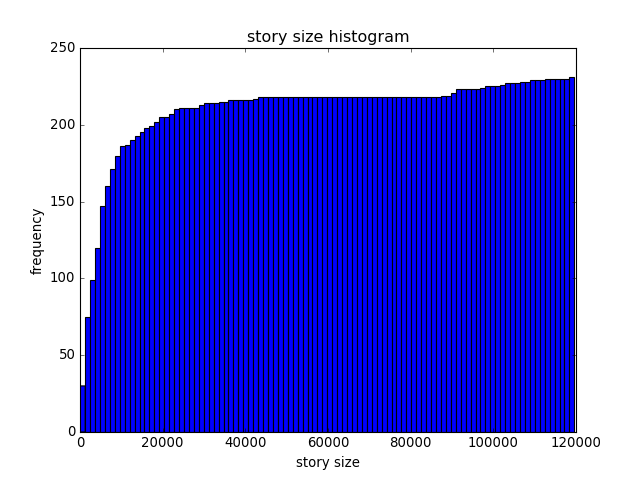

In [3]:
import matplotlib.pyplot as plt
%matplotlib nbagg

plt.hist(story_size_list,bins=100,cumulative=True)
plt.title("story size histogram")
plt.xlabel("story size")
plt.ylabel("frequency")

In [ ]:
import pickle
import time
batch_size=1
vocab,story_max=pickle.load(open("./korean_memnet_search_data/vocab_story_max.pkl","rb"))
print(len(vocab))
print(story_max)
gpu_options = tf.GPUOptions(allow_growth = True)
with tf.Graph().as_default(),tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options,allow_soft_placement = True)) as sess:
    tick=time.time()
    a=MN(vocab,1,300,story_max,1,batch_size,sess)
    print(time.time()-tick)
    input()
    for idx in range(231):
        print(idx)
        
        tick=time.time()
        data=pickle.load(open("./korean_memnet_search_data/korean_memnet_search_data_"+str(idx)+".pkl","rb"))
        print(time.time()-tick)
        tick=time.time()
        train_data,valid_data=a.preprocessing_dict([data],1)
        print(time.time()-tick)
        print(len(train_data))
        print(len(test_data))
        break

In [ ]:
import tensorflow as tf
import numpy as np
import nltk
import math


class MN():
    def __init__(self,vocab,memory_dim,memory_max,story_max,hop,batch_size,session):
        self.vocab=vocab
        self.vocab_dict=dict()
        for idx in range(len(vocab)):
            self.vocab_dict[vocab[idx]]=idx
        
        
        self.story_max=story_max
        
        self.hop=hop
        self.batch_size=batch_size
        
        self.memory_max=memory_max
        self.memory_dim=memory_dim
        #self.init_memory()
        self.memory=self.init_memory()
        
        #self.initializer=tf.random_normal_initializer(stddev=0.1)
        self.session=session
        self.init_tf_variable()
        
        init_tf=tf.initialize_all_variables()
        
        self.session.run(init_tf)
        
    def return_memory(self):
        return self.memory
    
    def init_tf_variable(self):
        for d in ['/gpu:0', '/gpu:1','/gpu:2','/gpu:3']:
            with tf.device(d):
                #self.story_embedding_W=tf.Variable(self.initializer)
                self.story_embedding_W=tf.Variable(tf.truncated_normal([len(self.vocab),self.memory_dim],stddev=1.0/math.sqrt(float(len(self.vocab)))),name="story_embedding_W")
                #self.story_embedding_W=tf.Variable(tf.truncated_normal([len(self.vocab),self.memory_dim],stddev=0.1),name="story_embedding_W")
                #self.story_embedding_b=tf.Variable(tf.zeros([self.memory_dim]),name="story_embedding_b")

                self.query_embedding_W=tf.Variable(tf.truncated_normal([len(self.vocab),self.memory_dim],stddev=1.0/math.sqrt(float(len(self.vocab)))),name="query_embedding_W")
                #self.query_embedding_W=tf.Variable(tf.truncated_normal([len(self.vocab),self.memory_dim],stddev=0.1),name="query_embedding_W")
                #self.query_embedding_b=tf.Variable(tf.zeros([self.memory_dim]),name="query_embedding_b")

                self.output_W=tf.Variable(tf.truncated_normal([self.memory_dim,len(self.vocab)],stddev=1.0/math.sqrt(float(self.memory_dim))),name="output_W")
                #self.output_W=tf.Variable(tf.truncated_normal([self.memory_dim,len(self.vocab)],stddev=0.1),name="output_W")
                #self.output_b=tf.Variable(tf.zeros([len(self.vocab)]),name="output_b")

                self.TA = tf.Variable(tf.truncated_normal([self.story_max,self.memory_dim],stddev=0.1))

                self.story_batch=tf.placeholder(tf.float32,[self.batch_size,self.story_max,len(self.vocab)])
                self.query_batch=tf.placeholder(tf.float32,[self.batch_size,1,len(self.vocab)])
                self.answer_batch=tf.placeholder(tf.float32,[self.batch_size,1,len(self.vocab)])
                self.memory_init_flag_batch=tf.placeholder(tf.int32,[self.batch_size])


                self.cross_entropy_sum=tf.constant(0.0)
                self.predict_list=tf.constant([[0.0]*len(self.vocab)])
                self.cross_entropy_list=tf.constant([])
                self.embedding_story=tf.add(tf.matmul(self.story_batch[0],self.story_embedding_W),self.TA) 
                for idx in range(self.batch_size):
                    #print(tf.constant(1))
                    #print()

                    #self.memory=tf.mul(self.memory,tf.sub(tf.constant(1.0),tf.cast(self.memory_init_flag_batch[idx],dtype=tf.float32)))
                    #self.memory_pointer=tf.mul(self.memory_pointer,tf.sub(tf.constant(1),self.memory_init_flag_batch[idx]))
                    #self.embedding_story=tf.matmul(self.story_batch[idx],self.story_embedding_W)+self.story_embedding_b
                    #embedding_query=tf.matmul(self.query_batch[idx],self.query_embedding_W)+self.query_embedding_b
                    #self.memory=tf.cond(tf.equal(self.memory_init_flag_batch[idx],tf.constant(1)),self.init_memory,self.return_memory)

                    embedding_query=tf.matmul(self.query_batch[idx],self.query_embedding_W)
                    #tf.scatter_update(self.memory,self.memory_pointer,self.embedding_story)

                    #self.memory=tf.concat(0,[self.memory,self.embedding_story])
                    """
                    for elem in tf.split(0,self.embedding_story.get_shape()[0],self.embedding_story):
                        #print(self.memory)
                        self.memory=tf.concat(0,[self.memory,elem])
                        #self.memorytf.reshape(elem,[-1])
                        #self.memory_pointer=tf.add(self.memory_pointer,1)
                    """
                    #self.memory=tf.concat(self.memory,self.embedding_story)
                    self.u=embedding_query
                    for i in range(self.hop):



                        self.attention=tf.nn.softmax(tf.reshape(tf.reduce_sum(tf.mul(self.embedding_story,self.u),1),[1,-1]))
                        #self.attention=tf.nn.softmax(tf.reshape(tf.reduce_sum(tf.mul(self.memory[1:],self.u),1),[1,-1]))
                        self.attended_embedding=tf.matmul(self.attention,self.embedding_story)
                        #self.attended_embedding=tf.matmul(self.attention,self.memory[1:])
                        self.u=tf.add(self.u,self.attended_embedding)



                        #self.predict=self.attended_embedding+self.embedding_query
                        #self.predict=tf.matmul(self.attended_embedding+self.embedding_query,self.output_W)+self.output_b
                    #predict=tf.matmul(self.u,self.output_W)+self.output_b
                    predict=tf.matmul(self.u,self.output_W)
                    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(predict, tf.cast(self.answer_batch[idx], tf.float32), name="cross_entropy")
                    self.cross_entropy_list=tf.concat(0,[self.cross_entropy_list,cross_entropy])
                    #self.cross_entropy_sum=tf.add(self.cross_entropy_sum,tf.reduce_sum(cross_entropy))

                    #self.predict_list=tf.cond(tf.equal(self.predict_list,tf.constant([[]])),
                    #self.predict_list=tf.cond(tf.constant(self.predict_list==tf.constant([[]])),
                    #                          lambda:tf.concat(1,[self.predict_list,tf.nn.softmax(predict)]),lambda:tf.concat(0,[self.predict_list,tf.nn.softmax(predict)]))
                    self.predict_list=tf.concat(0,[self.predict_list,tf.nn.softmax(predict)])
                self.predict_list=self.predict_list[1:]
                self.cross_entropy_sum=tf.reduce_sum(self.cross_entropy_list)

                story_embedding_W_hist=tf.histogram_summary("story_embedding_W",self.story_embedding_W)
                #story_embedding_b_hist=tf.histogram_summary("story_embedding_b",self.story_embedding_b)
                query_embedding_W_hist=tf.histogram_summary("query_embedding_W",self.query_embedding_W)
                #query_embedding_b_hist=tf.histogram_summary("query_embedding_b",self.query_embedding_b)
                output_W_hist=tf.histogram_summary("output_W",self.output_W)
                #output_b_hist=tf.histogram_summary("output_b",self.output_b)
                cross_entropy_sum_scalar = tf.scalar_summary("cross_entropy_sum",self.cross_entropy_sum)
                self.merged=tf.merge_all_summaries()
                self.writer=tf.train.SummaryWriter("/home/asd36952/tfbd/memnet/mymem_korean_hop_batch_search",self.session.graph)

                self.train_step=tf.train.AdamOptimizer(learning_rate=1e-2).minimize(self.cross_entropy_sum)
                #self.train_step=tf.contrib.layers.optimize_loss(loss=self.cross_entropy_sum,learning_rate=1e-2,optimizer='Adam',gradient_noise_scale=1e-4,global_step=tf.contrib.framework.get_global_step())
                #grads_and_vars = tf.train.AdamOptimizer(learning_rate=1e-2).compute_gradients(self.cross_entropy_sum)
                #grads_and_vars = [(tf.clip_by_norm(g, 40), v) for g,v in grads_and_vars]
                #self.train_step = tf.train.AdamOptimizer(learning_rate=1e-2).apply_gradients(grads_and_vars)
    
    def batch_fit(self,train_data,epoch=1000):
        train_data,valid_data=self.preprocessing_dict(train_data)
        num_train=np.array(train_data).shape[0]
        num_valid=np.array(valid_data).shape[0]
                                
        for ep in range(epoch):
            #np.random.shuffle(train_data)
            for idx in range(int(num_train/self.batch_size)):
                if num_train-idx*self.batch_size<self.batch_size:
                    break
                batch_train=train_data[idx*self.batch_size:(idx+1)*self.batch_size]
                #print(np.array(np.array(np.array(batch_train)[:,1].tolist()).reshape(-1,1,len(self.vocab)).tolist()).shape)
                summary,_=self.session.run([self.merged,self.train_step],feed_dict={self.story_batch:np.array(batch_train)[:,0].tolist(),
                                                              self.query_batch:np.array(np.array(batch_train)[:,1].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                                              self.answer_batch:np.array(np.array(batch_train)[:,2].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                                              self.memory_init_flag_batch:np.array(batch_train)[:,3].tolist()})
                self.writer.add_summary(summary,ep*num_train+idx)
            
            if (ep+1)%10==0:
                total_cross_ent=0
                for idx in range(int(num_train/self.batch_size)):
                    if num_train-idx*self.batch_size<self.batch_size:
                        break
                    
                    total_cross_ent+=self.session.run([self.cross_entropy_sum],feed_dict={self.story_batch:np.array(batch_train)[:,0].tolist(),
                                                              self.query_batch:np.array(np.array(batch_train)[:,1].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                                              self.answer_batch:np.array(np.array(batch_train)[:,2].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                                              self.memory_init_flag_batch:np.array(batch_train)[:,3].tolist()})[0]
                print(total_cross_ent)
                total=0
                correct=0
                for idx in range(int(num_train/self.batch_size)):
                    if num_train-idx*self.batch_size<self.batch_size:
                        break
                    batch_train=train_data[idx*self.batch_size:(idx+1)*self.batch_size]
                    predict_list=self.session.run(self.predict_list,feed_dict={self.story_batch:np.array(batch_train)[:,0].tolist(),
                                              self.query_batch:np.array(np.array(batch_train)[:,1].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                              self.answer_batch:np.array(np.array(batch_train)[:,2].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                              self.memory_init_flag_batch:np.array(batch_train)[:,3].tolist()})
                    #print(predict_list)
                    answer_list=np.array(np.array(batch_train)[:,2].tolist()).reshape(-1,1,len(self.vocab)).tolist()
                    for idx in range(self.batch_size):
                        total+=1
                        if np.argmax(predict_list[idx])==np.argmax(answer_list[idx]):
                            correct+=1
                print(total)
                print(correct)
                print(correct/total)
                print("#############################")
                total=0
                correct=0
                for idx in range(int(num_valid/self.batch_size)):
                    if num_valid-idx*self.batch_size<self.batch_size:
                        break
                    batch_valid=valid_data[idx*self.batch_size:(idx+1)*self.batch_size]
                    predict_list=self.session.run(self.predict_list,feed_dict={self.story_batch:np.array(batch_valid)[:,0].tolist(),
                                              self.query_batch:np.array(np.array(batch_valid)[:,1].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                              self.answer_batch:np.array(np.array(batch_valid)[:,2].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                              self.memory_init_flag_batch:np.array(batch_valid)[:,3].tolist()})
                    #print(predict_list)
                    answer_list=np.array(np.array(batch_valid)[:,2].tolist()).reshape(-1,1,len(self.vocab)).tolist()
                    for idx in range(self.batch_size):
                        total+=1
                        if np.argmax(predict_list[idx])==np.argmax(answer_list[idx]):
                            correct+=1
                print(total)
                print(correct)
                print(correct/total)
                print("#############################")
                print("#############################")
        
    def fit(self,train_data,epoch=2000):
        train_data,valid_data=self.preprocessing(train_data)
        print("Learning ...")
        for ep in range(epoch):
            for story,query,answer,memory_init_flag in train_data:
                #print(story)
                summary,_=self.session.run([self.merged,self.train_step],feed_dict={self.story:story,self.query:[query],self.answer:[answer],self.memory_init_flag:memory_init_flag})
                self.writer.add_summary(summary,ep)
            if (ep+1)%10==0:
                total=0
                correct=0
                for story,query,answer,memory_init_flag in train_data:
                    total+=1
                    if self.vocab[np.argmax(self.session.run([self.predict],feed_dict={self.story:story,self.query:[query],self.answer:[answer],
                                                                                       self.memory_init_flag:memory_init_flag}))]==self.vocab[np.argmax(answer)]:
                        correct+=1
                print("train")
                print(total)
                print(correct)
                print(correct/total)
                total=0
                correct=0
                for story,query,answer,memory_init_flag in valid_data:
                    total+=1
                    if self.vocab[np.argmax(self.session.run([self.predict],feed_dict={self.story:story,self.query:[query],self.answer:[answer],
                                                                                       self.memory_init_flag:memory_init_flag}))]==self.vocab[np.argmax(answer)]:
                        correct+=1
                print("valid")
                print(total)
                print(correct)
                print(correct/total)
        for story,query,answer,memory_init_flag in train_data:
            print(self.vocab[np.argmax(self.session.run([self.predict],feed_dict={self.story:story,self.query:[query],self.answer:[answer],self.memory_init_flag:memory_init_flag}))])
            print(self.vocab[np.argmax(answer)])
            print("#############################")
        print("#############################")
        for story,query,answer,memory_init_flag in valid_data:
            print(self.vocab[np.argmax(self.session.run([self.predict],feed_dict={self.story:story,self.query:[query],self.answer:[answer],self.memory_init_flag:memory_init_flag}))])
            print(self.vocab[np.argmax(answer)])
            print("#############################")
        
        
        #print(self.session.run([self.embedding_story,self.emdedding_query],feed_dict={self.story:story,self.query:query,self.answer:answer,self.memory_init_flag:memory_init_flag}))
    
    def preprocessing(self,train_data,validation_cut=0.8):
        preprocessed_data=[]
        for story,query,answer,memory_init_flag in train_data:
            story_list=[]
            for sentence in story:
                sentence_vector=[0]*len(self.vocab)
                for word in sentence:
                    sentence_vector[self.vocab.index(word)]=1
                story_list.append(sentence_vector)
            for _ in range(self.story_max-len(story_list)):
                story_list.append([0]*len(self.vocab))
            query_vector=[0]*len(self.vocab)
            for word in query:
                query_vector[self.vocab.index(word)]=1
            answer_vector=[0]*len(self.vocab)
            for word in answer:
                answer_vector[self.vocab.index(word)]=1
            preprocessed_data.append([story_list,query_vector,answer_vector,memory_init_flag])
        #print(preprocessed_data)
        return preprocessed_data[:int(len(preprocessed_data)*validation_cut)],preprocessed_data[int(len(preprocessed_data)*validation_cut):]
    
    def preprocessing_dict(self,train_data,validation_cut=0.8):
        preprocessed_data=np.empty([0,4])
        for story,query,answer,memory_init_flag in train_data:
            story_list=np.empty([0,len(self.vocab)])
            print(1)
            print(len(story))
            for sentence in story:
                sentence_vector=np.array([0]*len(self.vocab))
                for word in sentence:
                    sentence_vector[self.vocab_dict[word]]=1
                np.append(story_list,sentence_vector.reshape([1,-1]),0)
            print(3)
            for _ in range(self.story_max-len(story_list)):
                np.append(story_list,[0]*len(self.vocab))
            query_vector=np.array([0]*len(self.vocab))
            print(4)
            for word in query:
                query_vector[self.vocab_dict[word]]=1
            answer_vector=np.array([0]*len(self.vocab))
            print(5)
            for word in answer:
                answer_vector[self.vocab_dict[word]]=1
            np.append(preprocessed_data,[[story_list,query_vector,answer_vector,memory_init_flag]],0)
        #print(preprocessed_data)
        return preprocessed_data[:int(len(preprocessed_data)*validation_cut)],preprocessed_data[int(len(preprocessed_data)*validation_cut):]
    
    
    def init_memory(self):
        return tf.constant([[0.0]*self.memory_dim],dtype=tf.float32)
        #self.memory=tf.Variable(initial_value=[[0.0]*self.memory_dim]*self.memory_max,trainable=False)
        #self.memory=[[0.0]*self.memory_dim]*self.memory_max
        #self.memory_pointer=tf.constant(0)

In [ ]:
import numpy as np

a=np.array([[1,2,3],[4,5,6,],[7,8,9]])
b=np.array([1,2,3])
c=np.array([4,5,6])
print(np.sum(a,1))
print(np.sum(b*c[:,np.newaxis],1))
print((np.identity(3)-c))
print((np.identity(3)-c)*b[:,np.newaxis])
print(np.sum((np.identity(3)-c)*b[:,np.newaxis],1))
print(b*c)
print(b*c[:,np.newaxis])
print(a.T)
print(1-b)
#a.put(np.array([4,4,4]))
#print(a)
print(3.6460299491882324*432/3600)

In [ ]:
from data_utils import load_task
from itertools import chain
ids = range(1, 21)
train, test = [], []
for i in ids:
    train+= load_task("data/tasks_1-20_v1-2/en/", i)[0]
    test+=load_task("data/tasks_1-20_v1-2/en/", i)[1]
    #train.append(tr)
    #test.append(te)
#data = list(chain.from_iterable(train + test))
#print(train[0])
#train, test = load_task("data/tasks_1-20_v1-2/en/", 1)
#print(train)
vocab=[]
story_max=0
train_new=[]
for story,query,answer in train:
    story_max=max(story_max,len(story))
    for sent in story:
        for word in sent:
            vocab.append(word)
    for word in query:
        vocab.append(word)
    for word in answer:
        vocab.append(word)
    train_new.append([story,query,answer,1])
vocab=list(set(vocab))
print(train_new[0])
print(len(train_new))

with tf.Session() as sess:
    a=MN(vocab,20,300,story_max,3,100,sess)
    a.batch_fit(train_new,epoch=100)

In [ ]:
import tensorflow as tf
import numpy as np
import nltk
import math

class MN():
    def __init__(self,vocab,memory_dim,memory_max,story_max,hop,batch_size,session):
        self.vocab=vocab
        self.vocab_dict=dict()
        for idx in range(len(vocab)):
            self.vocab_dict[vocab[idx]]=idx+1
        
        self.story_max=story_max
        
        self.hop=hop
        self.batch_size=batch_size
        
        self.memory_max=memory_max
        self.memory_dim=memory_dim
        #self.init_memory()
        self.memory=self.init_memory()
        
        #self.initializer=tf.random_normal_initializer(stddev=0.1)
        self.session=session
        self.init_tf_variable()
        
        init_tf=tf.initialize_all_variables()
        
        self.session.run(init_tf)
        
    def return_memory(self):
        return self.memory
    
    def init_tf_variable(self):
        #self.story_embedding_W=tf.Variable(self.initializer)
        self.story_embedding_W=tf.Variable(tf.truncated_normal([len(self.vocab),self.memory_dim],stddev=1.0/math.sqrt(float(len(self.vocab)))),name="story_embedding_W")
        #self.story_embedding_W=tf.Variable(tf.truncated_normal([len(self.vocab),self.memory_dim],stddev=0.1),name="story_embedding_W")
        #self.story_embedding_b=tf.Variable(tf.zeros([self.memory_dim]),name="story_embedding_b")
        
        self.query_embedding_W=tf.Variable(tf.truncated_normal([len(self.vocab),self.memory_dim],stddev=1.0/math.sqrt(float(len(self.vocab)))),name="query_embedding_W")
        #self.query_embedding_W=tf.Variable(tf.truncated_normal([len(self.vocab),self.memory_dim],stddev=0.1),name="query_embedding_W")
        #self.query_embedding_b=tf.Variable(tf.zeros([self.memory_dim]),name="query_embedding_b")
        
        self.output_W=tf.Variable(tf.truncated_normal([self.memory_dim,len(self.vocab)],stddev=1.0/math.sqrt(float(self.memory_dim))),name="output_W")
        #self.output_W=tf.Variable(tf.truncated_normal([self.memory_dim,len(self.vocab)],stddev=0.1),name="output_W")
        #self.output_b=tf.Variable(tf.zeros([len(self.vocab)]),name="output_b")
        
        self.TA = tf.Variable(tf.truncated_normal([self.story_max,self.memory_dim],stddev=0.1))
        
        self.story_batch=tf.placeholder(tf.float32,[self.batch_size,self.story_max,len(self.vocab)])
        self.query_batch=tf.placeholder(tf.float32,[self.batch_size,1,len(self.vocab)])
        self.answer_batch=tf.placeholder(tf.float32,[self.batch_size,1,len(self.vocab)])
        self.memory_init_flag_batch=tf.placeholder(tf.int32,[self.batch_size])
        
        
        self.cross_entropy_sum=tf.constant(0.0)
        self.predict_list=tf.constant([[0.0]*len(self.vocab)])
        self.cross_entropy_list=tf.constant([])
        for idx in range(self.batch_size):
            #print(tf.constant(1))
            #print()
            
            #self.memory=tf.mul(self.memory,tf.sub(tf.constant(1.0),tf.cast(self.memory_init_flag_batch[idx],dtype=tf.float32)))
            #self.memory_pointer=tf.mul(self.memory_pointer,tf.sub(tf.constant(1),self.memory_init_flag_batch[idx]))
            #self.embedding_story=tf.matmul(self.story_batch[idx],self.story_embedding_W)+self.story_embedding_b
            #embedding_query=tf.matmul(self.query_batch[idx],self.query_embedding_W)+self.query_embedding_b
            #self.memory=tf.cond(tf.equal(self.memory_init_flag_batch[idx],tf.constant(1)),self.init_memory,self.return_memory)
            self.embedding_story=tf.add(tf.matmul(self.story_batch[idx],self.story_embedding_W),self.TA) 
            embedding_query=tf.matmul(self.query_batch[idx],self.query_embedding_W)
            #tf.scatter_update(self.memory,self.memory_pointer,self.embedding_story)
            
            #self.memory=tf.concat(0,[self.memory,self.embedding_story])
            """
            for elem in tf.split(0,self.embedding_story.get_shape()[0],self.embedding_story):
                #print(self.memory)
                self.memory=tf.concat(0,[self.memory,elem])
                #self.memorytf.reshape(elem,[-1])
                #self.memory_pointer=tf.add(self.memory_pointer,1)
            """
            #self.memory=tf.concat(self.memory,self.embedding_story)
            self.u=embedding_query
            for i in range(self.hop):
                

                
                self.attention=tf.nn.softmax(tf.reshape(tf.reduce_sum(tf.mul(self.embedding_story,self.u),1),[1,-1]))
                #self.attention=tf.nn.softmax(tf.reshape(tf.reduce_sum(tf.mul(self.memory[1:],self.u),1),[1,-1]))
                self.attended_embedding=tf.matmul(self.attention,self.embedding_story)
                #self.attended_embedding=tf.matmul(self.attention,self.memory[1:])
                self.u=tf.add(self.u,self.attended_embedding)
                
                
                
                #self.predict=self.attended_embedding+self.embedding_query
                #self.predict=tf.matmul(self.attended_embedding+self.embedding_query,self.output_W)+self.output_b
            #predict=tf.matmul(self.u,self.output_W)+self.output_b
            predict=tf.matmul(self.u,self.output_W)
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(predict, tf.cast(self.answer_batch[idx], tf.float32), name="cross_entropy")
            self.cross_entropy_list=tf.concat(0,[self.cross_entropy_list,cross_entropy])
            #self.cross_entropy_sum=tf.add(self.cross_entropy_sum,tf.reduce_sum(cross_entropy))
          
            #self.predict_list=tf.cond(tf.equal(self.predict_list,tf.constant([[]])),
            #self.predict_list=tf.cond(tf.constant(self.predict_list==tf.constant([[]])),
            #                          lambda:tf.concat(1,[self.predict_list,tf.nn.softmax(predict)]),lambda:tf.concat(0,[self.predict_list,tf.nn.softmax(predict)]))
            self.predict_list=tf.concat(0,[self.predict_list,tf.nn.softmax(predict)])
        self.predict_list=self.predict_list[1:]
        self.cross_entropy_sum=tf.reduce_sum(self.cross_entropy_list)
        
        story_embedding_W_hist=tf.histogram_summary("story_embedding_W",self.story_embedding_W)
        #story_embedding_b_hist=tf.histogram_summary("story_embedding_b",self.story_embedding_b)
        query_embedding_W_hist=tf.histogram_summary("query_embedding_W",self.query_embedding_W)
        #query_embedding_b_hist=tf.histogram_summary("query_embedding_b",self.query_embedding_b)
        output_W_hist=tf.histogram_summary("output_W",self.output_W)
        #output_b_hist=tf.histogram_summary("output_b",self.output_b)
        cross_entropy_sum_scalar = tf.scalar_summary("cross_entropy_sum",self.cross_entropy_sum)
        self.merged=tf.merge_all_summaries()
        self.writer=tf.train.SummaryWriter("/home/asd36952/tfbd/memnet/mymem_babi_hop_batch",self.session.graph)
        
        self.train_step=tf.train.AdamOptimizer(learning_rate=1e-2).minimize(self.cross_entropy_sum)
        #self.train_step=tf.contrib.layers.optimize_loss(loss=self.cross_entropy_sum,learning_rate=1e-2,optimizer='Adam',gradient_noise_scale=1e-4,global_step=tf.contrib.framework.get_global_step())
        #grads_and_vars = tf.train.AdamOptimizer(learning_rate=1e-2).compute_gradients(self.cross_entropy_sum)
        #grads_and_vars = [(tf.clip_by_norm(g, 40), v) for g,v in grads_and_vars]
        #self.train_step = tf.train.AdamOptimizer(learning_rate=1e-2).apply_gradients(grads_and_vars)
    
    def batch_pred(self,data):
        data, _ = self.preprocessing(data,1)
        num_data=np.array(data).shape[0]
        predict_list=[]
        for idx in range(int(num_data/self.batch_size)):
            batch_data=data[idx*self.batch_size:(idx+1)*self.batch_size]
            predict_list+=self.session.run(self.predict_list,feed_dict={self.story_batch:np.array(batch_train)[:,0].tolist(),
                                              self.query_batch:np.array(np.array(batch_train)[:,1].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                              self.answer_batch:np.array(np.array(batch_train)[:,2].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                              self.memory_init_flag_batch:np.array(batch_train)[:,3].tolist()})
        return predict_list
    
    def batch_fit(self,train_data,epoch=1000):
        train_data,valid_data=self.preprocessing(train_data)
        num_train=np.array(train_data).shape[0]
        num_valid=np.array(valid_data).shape[0]
                                
        for ep in range(epoch):
            #np.random.shuffle(train_data)
            for idx in range(int(num_train/self.batch_size)):
                if num_train-idx*self.batch_size<self.batch_size:
                    break
                batch_train=train_data[idx*self.batch_size:(idx+1)*self.batch_size]
                #print(np.array(np.array(np.array(batch_train)[:,1].tolist()).reshape(-1,1,len(self.vocab)).tolist()).shape)
                summary,_=self.session.run([self.merged,self.train_step],feed_dict={self.story_batch:np.array(batch_train)[:,0].tolist(),
                                                              self.query_batch:np.array(np.array(batch_train)[:,1].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                                              self.answer_batch:np.array(np.array(batch_train)[:,2].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                                              self.memory_init_flag_batch:np.array(batch_train)[:,3].tolist()})
                self.writer.add_summary(summary,ep*num_train+idx)
            

            total_cross_ent=0
            for idx in range(int(num_train/self.batch_size)):
                if num_train-idx*self.batch_size<self.batch_size:
                    break

                total_cross_ent+=self.session.run([self.cross_entropy_sum],feed_dict={self.story_batch:np.array(batch_train)[:,0].tolist(),
                                                          self.query_batch:np.array(np.array(batch_train)[:,1].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                                          self.answer_batch:np.array(np.array(batch_train)[:,2].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                                          self.memory_init_flag_batch:np.array(batch_train)[:,3].tolist()})[0]
            print(total_cross_ent)
            total=0
            correct=0
            for idx in range(int(num_train/self.batch_size)):
                if num_train-idx*self.batch_size<self.batch_size:
                    break
                batch_train=train_data[idx*self.batch_size:(idx+1)*self.batch_size]
                predict_list=self.session.run(self.predict_list,feed_dict={self.story_batch:np.array(batch_train)[:,0].tolist(),
                                          self.query_batch:np.array(np.array(batch_train)[:,1].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                          self.answer_batch:np.array(np.array(batch_train)[:,2].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                          self.memory_init_flag_batch:np.array(batch_train)[:,3].tolist()})
                #print(predict_list)
                answer_list=np.array(np.array(batch_train)[:,2].tolist()).reshape(-1,1,len(self.vocab)).tolist()
                for idx in range(self.batch_size):
                    total+=1
                    if np.argmax(predict_list[idx])==np.argmax(answer_list[idx]):
                        correct+=1
            print(total)
            print(correct)
            print(correct/total)
            print("#############################")
            total=0
            correct=0
            for idx in range(int(num_valid/self.batch_size)):
                if num_valid-idx*self.batch_size<self.batch_size:
                    break
                batch_valid=valid_data[idx*self.batch_size:(idx+1)*self.batch_size]
                predict_list=self.session.run(self.predict_list,feed_dict={self.story_batch:np.array(batch_valid)[:,0].tolist(),
                                          self.query_batch:np.array(np.array(batch_valid)[:,1].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                          self.answer_batch:np.array(np.array(batch_valid)[:,2].tolist()).reshape(-1,1,len(self.vocab)).tolist(),
                                          self.memory_init_flag_batch:np.array(batch_valid)[:,3].tolist()})
                #print(predict_list)
                answer_list=np.array(np.array(batch_valid)[:,2].tolist()).reshape(-1,1,len(self.vocab)).tolist()
                for idx in range(self.batch_size):
                    total+=1
                    if np.argmax(predict_list[idx])==np.argmax(answer_list[idx]):
                        correct+=1
            print(total)
            print(correct)
            print(correct/total)
            print("#############################")
            print("#############################")
        
    def fit(self,train_data,epoch=2000):
        train_data,valid_data=self.preprocessing(train_data)
        print("Learning ...")
        for ep in range(epoch):
            for story,query,answer,memory_init_flag in train_data:
                #print(story)
                summary,_=self.session.run([self.merged,self.train_step],feed_dict={self.story:story,self.query:[query],self.answer:[answer],self.memory_init_flag:memory_init_flag})
                self.writer.add_summary(summary,ep)
            if (ep+1)%10==0:
                total=0
                correct=0
                for story,query,answer,memory_init_flag in train_data:
                    total+=1
                    if self.vocab[np.argmax(self.session.run([self.predict],feed_dict={self.story:story,self.query:[query],self.answer:[answer],
                                                                                       self.memory_init_flag:memory_init_flag}))]==self.vocab[np.argmax(answer)]:
                        correct+=1
                print("train")
                print(total)
                print(correct)
                print(correct/total)
                total=0
                correct=0
                for story,query,answer,memory_init_flag in valid_data:
                    total+=1
                    if self.vocab[np.argmax(self.session.run([self.predict],feed_dict={self.story:story,self.query:[query],self.answer:[answer],
                                                                                       self.memory_init_flag:memory_init_flag}))]==self.vocab[np.argmax(answer)]:
                        correct+=1
                print("valid")
                print(total)
                print(correct)
                print(correct/total)
        for story,query,answer,memory_init_flag in train_data:
            print(self.vocab[np.argmax(self.session.run([self.predict],feed_dict={self.story:story,self.query:[query],self.answer:[answer],self.memory_init_flag:memory_init_flag}))])
            print(self.vocab[np.argmax(answer)])
            print("#############################")
        print("#############################")
        for story,query,answer,memory_init_flag in valid_data:
            print(self.vocab[np.argmax(self.session.run([self.predict],feed_dict={self.story:story,self.query:[query],self.answer:[answer],self.memory_init_flag:memory_init_flag}))])
            print(self.vocab[np.argmax(answer)])
            print("#############################")
        
        
        #print(self.session.run([self.embedding_story,self.emdedding_query],feed_dict={self.story:story,self.query:query,self.answer:answer,self.memory_init_flag:memory_init_flag}))
    
    def preprocessing(self,train_data,validation_cut=0.8):
        preprocessed_data=[]
        for story,query,answer,memory_init_flag in train_data:
            story_list=[]
            for sentence in story:
                sentence_vector=[0]*len(self.vocab)
                for word in sentence:
                    sentence_vector[self.vocab.index(word)]=1
                story_list.append(sentence_vector)
            for _ in range(self.story_max-len(story_list)):
                story_list.append([0]*len(self.vocab))
            query_vector=[0]*len(self.vocab)
            for word in query:
                query_vector[self.vocab.index(word)]=1
            answer_vector=[0]*len(self.vocab)
            for word in answer:
                answer_vector[self.vocab.index(word)]=1
            preprocessed_data.append([story_list,query_vector,answer_vector,memory_init_flag])
        #print(preprocessed_data)
        return preprocessed_data[:int(len(preprocessed_data)*validation_cut)],preprocessed_data[int(len(preprocessed_data)*validation_cut):]
            
    
    def init_memory(self):
        return tf.constant([[0.0]*self.memory_dim],dtype=tf.float32)
        #self.memory=tf.Variable(initial_value=[[0.0]*self.memory_dim]*self.memory_max,trainable=False)
        #self.memory=[[0.0]*self.memory_dim]*self.memory_max
        #self.memory_pointer=tf.constant(0)